# Portfolio assignment week 6

# 1. Decision Trees and Naive bayes
The scikit-learn library provides different parameters for decision trees and naive bayes. 

Based on the last code example [in the accompanying notebook](../Exercises/E_DT_NB.ipynb), add several new models to the `classifiers` variable. These models should have different parameters. For instance, create a new decision tree with a max depth of 1. Another possibility is to add different datasets or add noise.

Try to understand why some models behave differently than others. Give arguments what influences model performance and why.

# 2. Decision Tree Evaluation
As shown in the [in the accompanying notebook](../Exercises/E_DT_NB.ipynb) it is possible to visualize the decision tree. 

For this exercise, you can use your own dataset if that is eligable for supervised classification. Otherwise, you can use the [breast cancer dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset) which you can find on assemblix2019 (`/data/datasets/DS3/`). Go through the data science pipeline as you've done before:

1. Try to understand the dataset globally.
2. Load the data.
3. Exploratory analysis
4. Preprocess data (skewness, normality, etc.)
5. Modeling (cross-validation and training)
6. Evaluation
7. **Explanation**

Explain how the decision tree behaves under certain circumstances. What features seem important and how are the decisions made?

## Dataset
It is not fun to use the same dataset each time for each excersize :D. Consequently, I started to search for a fun and perfect dataset for this excercize (of course I participate in resit, and this is the reason that I have enough time to do this :D ). During my exploration of the concept of Decision Trees, I came across two interesting links (<a href="https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052" target="_blank">tds-link</a> and <a href="https://en.wikipedia.org/wiki/Sinking_of_the_Titanic" target="_blank">wiki</a>) that caught my attention. Upon skimming through the wiki link, I stumbled upon a section called "Casualties and survivors," which provided detailed information about the number of saved and lost passengers based on their gender and class. This dataset was sourced from an article written by L. Mersey in 1912 [1]. I found it intriguing that the author of the wiki link employed a treemap to categorize passengers, resulting in valuable insights into the casualties of this catastrophic event. Additionally, the tds-link utilized Decision Trees to classify the casualties and survivors based on their gender and age.Consequently, I found this topic fascinating to work on and present my own Decision tree model to describe the casualty of this catasrophic event. The Titanic dataset is extracted from this <a href="https://www.kaggle.com/datasets/vinicius150987/titanic3?resource=download" target="_blank">Kaggle</a> link.

[1] Mersey, L. (1999). The Loss of the Titanic, 1912. London: Stationery Office.

Thus, here I will delve into this dataset to extract the most reliable model for the number of lost and survived passengers. 

Like always, one can beging wit loading the data.

## Loading Data

In [2]:
# General Modules
import yaml
import os
import pandas as pd
import numpy as np
import graphviz
import time
import re
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Dataset module
from sklearn.model_selection import train_test_split

# preprocessing modules
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Classification modules
from sklearn import tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

# Metrics modules
from sklearn.metrics import accuracy_score

# Model selection modules
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [3]:
#inspired by https://fennaf.gitbook.io/bfvm22prog1/data-processing/configuration-files/yaml

def configReader():
    """
    explanation: This function open config,yaml file 
    and fetch the gonfigue file information
    input: ...
    output: configue file
    """
    with open("config.yaml", "r") as inputFile:
        config = yaml.safe_load(inputFile)
    return config

In [4]:
def dataframe_maker(config):
    file_directory, file_name = config.values()
    os.chdir(file_directory)
    df = pd.read_excel(file_name)#.drop('Unnamed: 32', axis=1)
    return df
df = dataframe_maker(configReader())
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


This dataset consists of 1309 samples (passengers) and 14 features. Although each feature has the potential to influence the model's outcome, some of them may not significantly impact the model's functionality. Therefore, understanding the nature of each feature becomes crucial for the subsequent steps in the data-science pipeline. This knowledge empowers researchers to discern whether a feature holds importance in the analysis.  Thus, all the features will be described in the following paragraphs.

1. **pclass**: presents ticket classes, a potentially significant feature that could have influenced the chances of survival. It is plausible that individuals from higher classes had a better chance of surviving, making this feature relevant for the analysis.

2. **survived**: shows the labels that whether a passenger lost his/her life or survived from this disastorous event.

3. **name**: contains the names of the passengers.

4. **sex**: includes the gender of the passengers, which can significantly influence the model's performance. During emergency conditions, women are often prioritized for protection, making this feature highly relevant and potentially impactful on the model's predictions.

5. **age**: This variable represents the age of the passengers, and once again, it can significantly impact the model's outcome. During emergency conditions, children are often given priority for protection, making this feature particularly relevant for predicting survival rates.

6. **sibsp**: is the number of siblings and spouse. It can have a slight effect on the outcome of the model. Maybe people with higher number of sibsp had less chance of surviving.

7. **parch**: this number preents the number of parents and children. This parameter is quite similar to privious one (sibsp).

8. **ticket**: contains the number of passengers' tickets. It seems irrelevant to the topic.

9. **fare**: includes the price of the tickets, which can be useful for classifying passengers based on their socio-economic status. Higher ticket prices might indicate a higher social class, while lower prices might correspond to a lower class. This feature can be valuable in categorizing passengers according to their economic standing.

10. **cabin**: consists of information about the numbers of cabins for which passengers paid. This feature could be significant as passengers from cabins near the deck might have had an advantage, reaching the surface of the ship more quickly, which could have increased their chances of survival.

11. **embarked**: includes the ports in which passengers are get into the ship.

12. **boat**: consists of the boats' codes with which some of the passengers survived.

13. **body**: contains the body numbers if did not survive and body was recovered. <a href="https://github.com/awesomedata/awesome-public-datasets/issues/351" target="_blank">link</a> 

14. **home.dest**: contains the home destination of all the the passengers.

Next part is the most vital part of this project which is **Data Inspection**.

### Data Inspection
There are different ways with which one can inspect a dataset. One way is by using statistics as numbers and another one is by using different types of figures. I try to cover a part of both here, but one can feel free to use all the relevant methods here. Using plots to describe datasets are mainly recommended to use when you need to present your data or outcome to your costumer or unexpert people.

In [38]:
def bar_plot_maker(xdata, ydata, title, xlabel, ylabel, bar_color, rotat=60):
    plt.figure(figsize=(8,6))
    plt.bar(xdata, ydata, color=bar_color)
    plt.xticks(rotation=rotat)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show


In [6]:
# Using this code from https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

def func(pct, allvals):
    # this function makes percentages for pie chart
    absolute = int(round(pct/100.*np.sum(list(allvals))))
    return f"{pct:.1f}%\n({absolute:d} people)"

def pie_chart_maker(data, label, title):
    # make the plit
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
    
    # make the pie chart
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

    # add the legend
    ax.legend(wedges, label,
            title="ports",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))


    plt.setp(autotexts, size=8, weight="bold")
    ax.set_title(title)

    plt.show()

In [7]:
def data_inspecter(df):
    # find the shape of data
    print(f'dataset has {df.shape[0]} observations, and {df.shape[1]} variables\n')

    # finding the information of this dataset
    print(f'{df.info()}\n')

    # extract the number of null values of the dataset
    null_values = df.isnull().sum().sum()
    print(f'the total number of null values in this dataset is {null_values}\n')

    # Find the unique values of different categorical variables
    class_values = list(df.pclass.unique())
    print(f'number of unique groups in pclass is {len(class_values)}\ngroups are:{class_values}\n')

    gender_values = list(df.sex.unique())
    print(f'number of unique groups in sex-var is {len(gender_values)}\ngroups are:{gender_values}\n')

    sibsp_values = list(df.sibsp.unique())
    print(f'number of unique groups in sibsp-var is {len(sibsp_values)}\ngroups are:{sibsp_values}\n')

    parch_values = list(df.parch.unique())
    print(f'number of unique groups in parch-var is {len(parch_values)}\ngroups are:{parch_values}\n')

    embark_values = list(df.embarked.unique())
    print(f'number of unique groups in embarked-var is {len(embark_values)}\ngroups are: {embark_values}\n')

    # Find the mean, max and min value of the age colmun
    print(f'The youngest passenger had {df.age.min()} years old\n')
    print(f'The oldest passenger had {df.age.max()} years old\n')
    print(f'The mean age of the passengers is: {round(df.age.mean(), 3)} years old\n')

    # Find the mean, max and min value of the tickets
    print(f'The cheapest ticket costs {df.fare.min()}\n')
    print(f'The most expensive ticket costs {df.fare.max()}\n')
    print(f'The average cost of the tickets is: {round(df.fare.mean(), 3)}\n')
    print(f'the number of passengers who paid the minimum price for the ticket is {pd.DataFrame(df[df.fare == 0.0]).shape[0]}')

data_inspecter(df)

dataset has 1309 observations, and 14 variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB
None

the total number of null values in this dataset is 3855

number of unique groups in pclass is 3
groups are:[1, 2, 3]

number of unique

Before delving into the analysis of the data_inspector function's outcome, it's crucial to acknowledge that employing a one-size-fits-all approach to inspecting data across all datasets might not be appropriate. While some datasets may share common features and can benefit from similar inspection techniques, such as identifying null values and unique labels in various columns, each dataset can possess unique attributes that necessitate customized inspection methods.

Using the same technique for all datasets could potentially lead to overlooking valuable information specific to each dataset. Therefore, it is advisable to be mindful of the dataset's characteristics and employ tailored inspection techniques accordingly. This approach allows for a more comprehensive understanding of the data and ensures that no crucial insights are missed during the analysis process.

Let's back to the data_inspector's outcome. Regarding the groups within different categorical valriabels, one can see that pclass contains 3 groups ('1', '2', and '3') to find which group is the wealthiest one, one can compare the ticket price of different groups.

In [8]:
def ticket_price_finder(df):
    df_copy = df.copy()

    # make a copy of the dataset and fill the null value of fare column with mean value
    df_copy.fare = df_copy.fare.fillna(value=df_copy.fare.mean())
    pclass_df = pd.DataFrame(df_copy.groupby('pclass'))

    # make a dictionary that its keys are classes and the values are a list of average
    # price of the ticket in that class and also the number of passengers in that class
    class_ticket_dic = {number+1:[round(pclass_df[1][number].fare.mean(), 3), 
                                  pclass_df[1][number].shape[0]] 
                                  for number in range(pclass_df.shape[0])}
    print(class_ticket_dic)
ticket_price_finder(df)

{1: [87.509, 323], 2: [21.179, 277], 3: [13.331, 709]}


The dictionary provided contains keys representing different classes, with corresponding values as lists containing the average ticket price and the number of passengers in each class. Notably, Class '1' corresponds to the first class, comprising the wealthiest passengers, as they paid significantly higher ticket prices on average. Class '2' represents the second class, while Class '3' denotes the third class. Interestingly, the number of passengers in the third class surpasses that of the other two classes, indicating the affordability of tickets for this class. Moreover, the maximum ticket price is more than 500 while the cheapest one is for free. Interestingly, 17 people could get into the sip without paying anything! They somehow were meeting their own death with this act!

Moreover, sibpa and parch variables represent family relationships. The former indicates the number of siblings and spouses of a passenger, while the latter represents the number of parents and children accompanying the individual. Consequently, to assess the influence of the number of family members, one approach is to sum these two columns, providing a more comprehensive understanding of their combined effect on a person's chances of survival.

The "embarked" column indicates the ports from which passengers boarded the ship, and there are three distinct ports represented by the codes 'S', 'C', and 'Q'. These ports are situated in three different countries: 'S' corresponds to 'Southampton' located in the UK, 'C' stands for 'Cherbourg' located in France, and 'Q' represents 'Queenstown' situated in Ireland. <a href="https://en.wikipedia.org/wiki/Sinking_of_the_Titanic" target="_blank">wiki</a> 

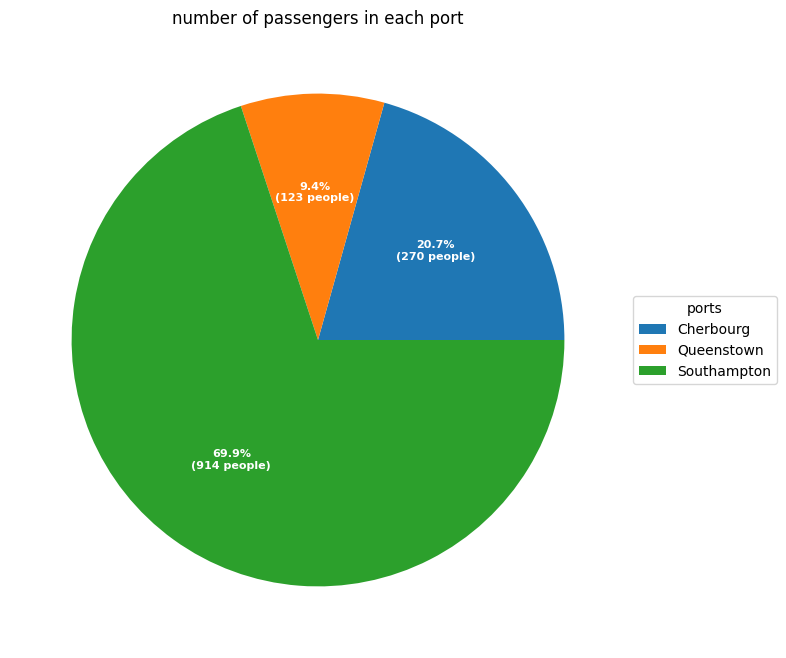

In [9]:
# Make a dictionary with harbours as key values, and the number of passengers as values
embarked_df = pd.DataFrame(df.groupby('embarked'))
embarked_dict = {embarked_df[0][number]:embarked_df[1][number].shape[0] 
                 for number in range(embarked_df.shape[0])}

# make a list of complete names od the harbours
label_list = ['Cherbourg', 'Queenstown', 'Southampton']
pie_chart_maker(data=embarked_dict.values(), label=label_list, title= 'number of passengers in each port')

The pie chart depicts that about 70% of the passengers boarded the ship from Southampton UK, which stands for two third of the passengers. Also, the embarking information of two passenger is missing since the dataset contains two null values for them.

Regarding age, the passengers on the ship ranged from infants as young as one and a half months old to elderly individuals aged 80 years. The average age was approximately 30 years. However, this column contains approximately 20% null values, a noticeable proportion. This column could be crucial and relevant to the survival chances, as often during such catastrophic events, efforts are made to save children. Various methods can be employed to fill these null values. One approach is to use the mean value to fill all the null entries, while another involves identifying the age distribution pattern among passengers and then generating stochastic ages for individuals without age data based on that pattern. To start with, I will use the mean value method.

Finally, addressing the issue of null values, it is evident from the bar chart and the above information provided that the 'body' column contains the highest number of null values. This is understandable since this variable represents information about individuals who perished during the tragic event, and their bodies were subsequently identified. As a result, those who survived or passed away but whose bodies were not recovered are marked as null in this column. This feature could prove helpful in deciphering the 'survived' label, which only contains values '0' and '1'. We will revisit the label column later.

The second to fourth places with considerable null values are occupied by 'cabin', 'boat', and 'home.dest'. 'Cabin' could be significant for the model, as it may contain data about the passengers' locations on the Titanic during the catastrophe, suggesting that those closer to the deck had a higher chance of survival. However, due to the substantial number of null values (approximately 78% of the 'cabin' data), we cannot use it for further investigation.

Regarding the 'boat' data, this column can once again assist in evaluating the 'survived' labels, as most individuals who boarded a lifeboat likely survived the disaster. Hence, null values might indicate that the person did not reach any of the boats and potentially failed to save themselves. Also, the 'home.dest' column predominantly contains information about passengers' homes, which is not relevant to this research.


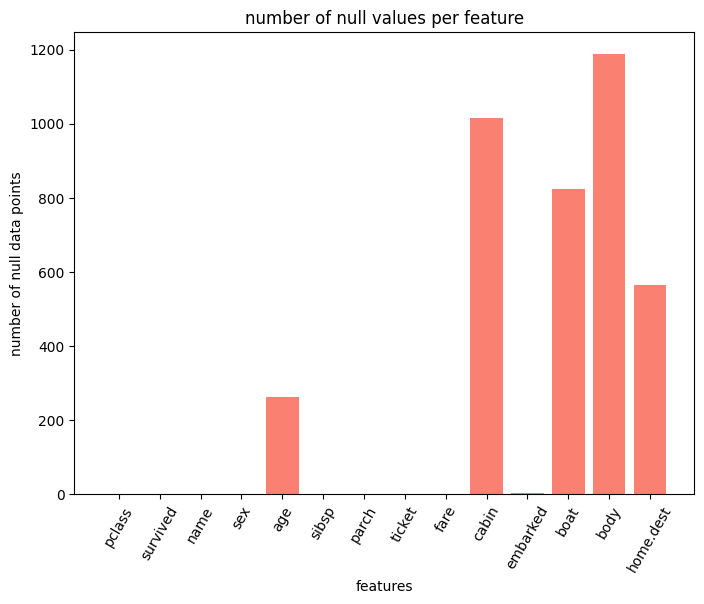

In [10]:
# sketch a bar-chart based on the null values
null_list = df.isnull().sum()
bar_plot_maker(xdata=null_list.index, ydata=null_list, xlabel='features', bar_color='salmon',
                title='number of null values per feature', ylabel='number of null data points')

Now, let's examine the most crucial column, the 'survived' column, which serves as our label data. As mentioned earlier, this column contains '0' and '1', but the Kaggle link does not explicitly state which value represents survival and which one represents death. To address this, we will explore other aspects of the dataset to determine this information. It is mentioned before that while 'body' and 'boat' columns have many null values, one can use them to find which label ('0' and '1') are survived and died. 

dataset 0 has 809 observations, and 14 variables

<class 'pandas.core.frame.DataFrame'>
Index: 809 entries, 2 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     809 non-null    int64  
 1   survived   809 non-null    int64  
 2   name       809 non-null    object 
 3   sex        809 non-null    object 
 4   age        619 non-null    float64
 5   sibsp      809 non-null    int64  
 6   parch      809 non-null    int64  
 7   ticket     809 non-null    object 
 8   fare       808 non-null    float64
 9   cabin      102 non-null    object 
 10  embarked   809 non-null    object 
 11  boat       9 non-null      object 
 12  body       121 non-null    float64
 13  home.dest  398 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 94.8+ KB
None

dataset 1 has 500 observations, and 14 variables

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 1300
Data columns (total 14

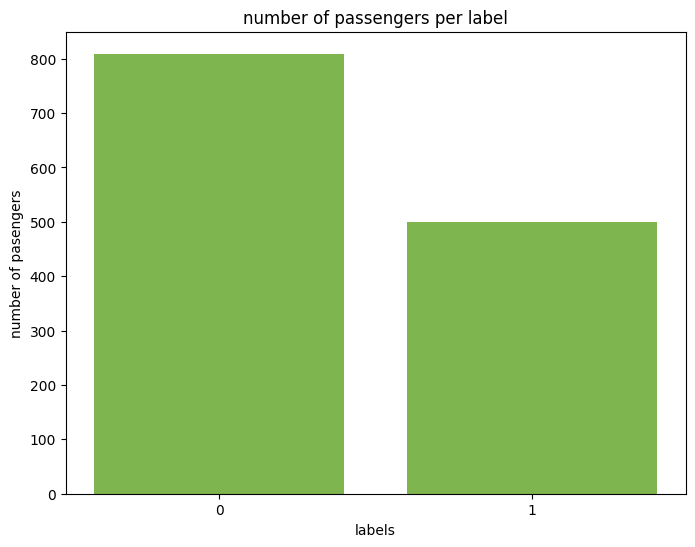

In [41]:
def label_column_inspecter(df):
    # compare the number of '0' and '1' labels in the dataset
    x_data = list(map(str, list(df.survived.value_counts().index)))
    bar_plot_maker(xdata=x_data, ydata=df.survived.value_counts(), xlabel='labels', bar_color='#7eb54e',
                    title='number of passengers per label', ylabel='number of pasengers', rotat=0)

    # Groupby the dataset based on label column
    survived_df = pd.DataFrame(df.groupby('survived'))

    # Iterate over the labels
    for number in range(survived_df.shape[0]):
        divided_df = survived_df[1][number]

        # find the shape of data
        print(f'dataset {survived_df[0][number]} has {divided_df.shape[0]} observations, and {divided_df.shape[1]} variables\n')

        # finding the information of this dataset
        print(f'{divided_df.info()}\n')

label_column_inspecter(df)

To begin with, there are 809 passengers categorized as '0' and 500 passengers categorized as '1'. This distribution leads us to infer that the '0' category likely represents the 'died' group, given that approximately three-fourths of the people aboard the Titanic lost their lives. Consequently, in a dataset like this, we would expect the number of deceased individuals to be higher than the number of survivors.

Additionally, when examining the 'boat' column's null values, we observe that only 9 passengers out of the 809 in the '0' category could be associated with a lifeboat after the accident, whereas this number is 477 out of 500 for the '1' category. This stark contrast suggests that only a limited number of passengers in the '0' category managed to reach a lifeboat, while nearly all passengers in the '1' category were able to board one after the accident. This observation strengthens our belief that the '1' category can be identified as the 'survived' group.

Moreover, analyzing the null values of the 'body' column reveals that 121 out of 809 passengers in the '0' group had their dead bodies recovered, while this number is 0 out of 500 for the '1' group. This stark difference further solidifies our inference since no dead bodies from the '1' group were found, while 121 dead bodies were recovered from the '0' group. Consequently, we can confidently conclude that the '0' group represents the 'died' or non-survived group, while the '1' group represents the 'survived' group.

As final words in this section, it is crucial to emphasize that data inspection is a fundamental and vital step in the data analysis pipeline. However, it can vary significantly from one dataset to another. While certain data columns may appear redundant for your immediate analysis needs, it is essential to remain aware that they might still hold value in other contexts or analytical tasks. Therefore, always approach data exploration with an open mind, as unexpected insights can arise from seemingly less relevant attributes. Keeping this in mind will help you make more informed decisions and extract meaningful information from the data.

After this extensive data inspecting part it is time to fix some problems in our dataset such as null values, redundant columns, and changing labels.

### Data Cleaning and Preprocessing
In this section, I will fix some of the problems of the dataset and prepare the dataset to be used as the input of the Decision Tree model. the issues are:

1. Dropping the redundant columns ('name', 'ticket', 'cabin', 'embarked', 'boat', 'body', 'home.dest').

2. Summing and merging 'sibsp' and 'parch' columns.

3. Filling missing values of 'age' and 'fare' columns.

4. Convert 'sex' column label to '0' for 'male' and '1' for 'female'. The reason is that the Decision Tree algorithm cannot convert string to numbers.

In [169]:
def df_preprocessor(df):
    corrected_df = df.copy()

    # drop the irrelevant columns
    corrected_df = corrected_df.iloc[:,:9].drop(columns=['name', 'ticket'])

    # merge  'parch' and 'sibsp'
    corrected_df.sibsp = corrected_df.loc[:,['sibsp', 'parch']].sum(axis=1)
    corrected_df = corrected_df.rename(columns={'sibsp':'family'}).drop(columns=['parch'])

    # Fill missing values of 'age' column with mean value
    corrected_df.age = corrected_df.age.fillna(value=corrected_df.age.mean())

    # Fill the missing value of 'fare' column with mean value
    corrected_df.fare = corrected_df.fare.fillna(value=corrected_df.fare.mean())

    # Convert 'sex' columns to '0' = male, '1' = 'female'
    corrected_df.sex = corrected_df.sex.replace(['male','female'],[0, 1])
    return corrected_df

corrected_df = df_preprocessor(df)
corrected_df.head()

,pclass,survived,sex,age,family,fare
0,1,1,1,29.0000,0,211.3375
1,1,1,0,0.9167,3,151.5500
2,1,0,1,2.0000,3,151.5500
3,1,0,0,30.0000,3,151.5500
4,1,0,1,25.0000,3,151.5500


In [170]:
# Print the number of null values in the cleaned dataset
corrected_df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
family      0
fare        0
dtype: int64

This is the dataset that we can use directly as the input of the Decision Tree model. The reason is that Decision Tree model does not need much data preprocessing steps. The only necessary thing can be the actual cleaned dataset to use as the input of the model. Consequently as the next step, I will implement the Decision Tree model for this dataset to find the accuracy of it.

### Decision Tree Implementation
Here I will use the GridSearchCV function to implement Decision Tree model. The reason is that this function can implement Cross-validation and arameter tuning at the same time. For more information you can always check the 'E_DT_NB.ipynb' file.

Before employing GridSearchCV to evaluate the performance of the Decision Tree model, it is intriguing to observe how each classifier, either independently or in combination with another classifier, can predict the survival rate. This preliminary analysis will offer valuable insights into the individual contributions of different features and their interactions in determining survival outcomes. Understanding these factors can aid in refining the Decision Tree model and potentially lead to better overall performance.

In [197]:
def tree_plotter(dt, features, classes, fig_size=(15, 15)):
    plt.figure(figsize=fig_size)
    tree.plot_tree(
        dt,
        feature_names=features,
        class_names=classes,
        filled=True,
        rounded=True,
        node_ids=True
    )
    plt.show()

In [198]:
# classification methods' implementation using GridSearchCV
def multiple_grid_search(estimator_dict, scoring_list, cv_number, refit_method, data_dict):

    final_dict = {}

    for name in estimator_dict.keys():
        print(name)
        start = time.time()
        # Create the GridSearchCV object
        grid_search = GridSearchCV(estimator=estimator_dict[name][0], param_grid=estimator_dict[name][1],
                                   scoring=scoring_list, cv=cv_number, refit=refit_method)

        # Fit the the best model to the data
        grid_search.fit(data_dict['x'], data_dict['y'])

        # Save the best estimator for each model
        final_dict[name] = {'best_model': grid_search.best_estimator_,
                            'best_parameters': grid_search.best_params_,
                            'best_score': grid_search.best_score_}

        end = time.time()
        print(f'time:{end - start}')
    # order the dictionary based on the magnitude of the scores
    final_dict = dict(
        sorted(final_dict.items(), key=lambda item: -1 * item[1]['best_score']))

    return final_dict

In [194]:
def decision_surface_plot(data, label_column, num_classes, colors, xlabel, ylabel, scatter_label):
    n_classes = num_classes
    plot_colors = colors

    # Sketch the plot
    fig, axes = plt.subplots(data.shape[1], data.shape[1], figsize=(20, 20))

    # Flatten the axes
    if data.shape[1] > 1:
        # flatten for easier manipulation
        axes.flatten()
    else:
        axes = [axes]

    # loop over all the features/classifiers
    for number in range(data.shape[1]**2):
        row_num = number // 5
        column_num = number % 5

        X = np.array(data.iloc[:, [row_num, column_num]])
        y = label_column

        # Train
        clf = tree.DecisionTreeClassifier().fit(X, y)

        # Plot the decision boundary
        decision_boundary_plot = DecisionBoundaryDisplay.from_estimator(
            clf,
            X,
            cmap=plt.cm.RdBu,
            response_method="predict",
            ax=axes[row_num, column_num],
        )

        # sketch the labels
        if column_num == 0:
            axes[row_num, column_num].set_ylabel(ylabel[row_num])

        if row_num >= data.shape[1]-1:
            axes[row_num, column_num].set_xlabel(xlabel[column_num])

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            axes[row_num, column_num].scatter(
                X[idx, 0],
                X[idx, 1],
                c=color,
                label=scatter_label[i],
                cmap=plt.cm.RdBu,
                edgecolor="black",
                s=15,
            )

    # add title and legend
    plt.suptitle(
        "Decision surface of decision trees trained on pairs of features")
    plt.legend(loc='lower right', borderpad=0, handletextpad=0)
    _ = plt.axis("tight")
    plt.show()

In [195]:
# Make X and y
X = corrected_df.drop(columns=['survived'])
y = corrected_df.survived

C:\Users\Parsian computer\AppData\Local\Temp\ipykernel_15452\653739979.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row_num, column_num].scatter(
C:\Users\Parsian computer\AppData\Local\Temp\ipykernel_15452\653739979.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row_num, column_num].scatter(
C:\Users\Parsian computer\AppData\Local\Temp\ipykernel_15452\653739979.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row_num, column_num].scatter(
C:\Users\Parsian computer\AppData\Local\Temp\ipykernel_15452\653739979.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row_num, column_num].scatter(
C:\Users\Parsian computer\AppData\Local\Temp\ipykernel_15452\653739979.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row_n

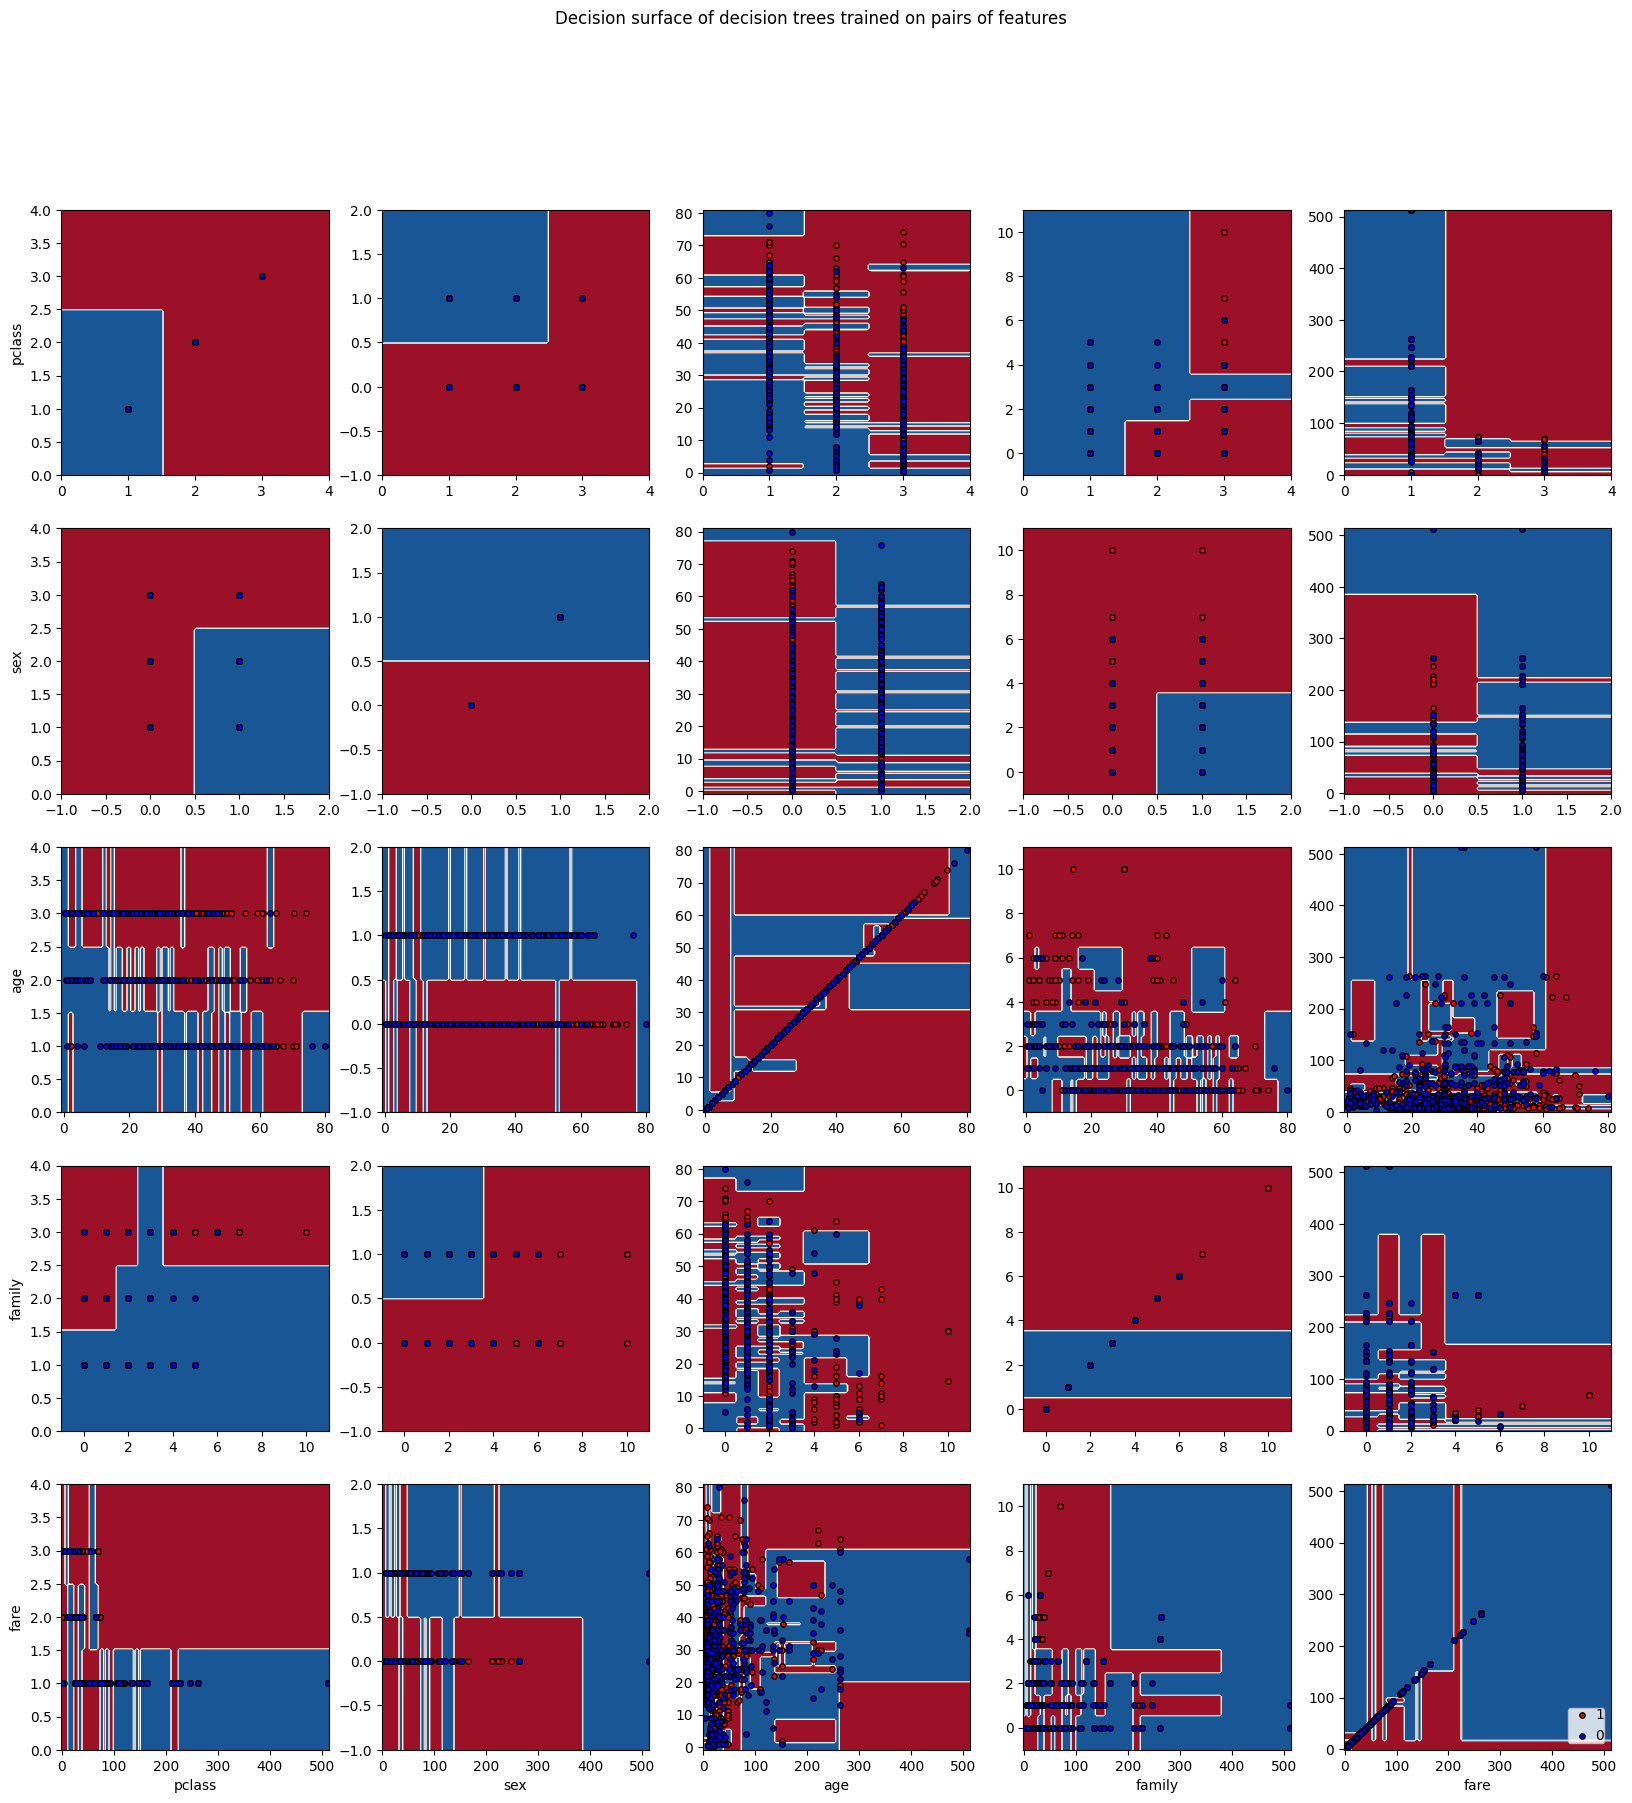

In [196]:
# make the contour plot
data = X
num_classes = 2
colors = 'rb'
xlabel = list(X.columns)
ylabel = list(X.columns)
scatter_label = list(y.unique())
decision_surface_plot(X, y, num_classes, colors, xlabel, ylabel, scatter_label)

This contour plot demonstrates that none of the individual features can solely separate the two classes from each other effectively. However, it is evident that when the 'age' feature is combined with other features, it exhibits a better discriminatory capability. Overall, this plot highlights the complexity of the relationship between the label column and the features. It underscores the fact that predicting the label using only one or two features is insufficient to capture the underlying patterns accurately. The interactions between multiple features play a significant role in determining the survival outcomes, making the classification problem more intricate. Now, let's have a look at GridSearchCV outcome.

In [174]:
# make parameter dictionary for decision tree
dt_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_impurity_decrease': [0, 1, 4],
    'ccp_alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.15, 0.2]

}

# Scoring list
scoring_list = ['f1_macro', 'recall_macro', 'roc_auc_ovo', 'accuracy']
# Make estimator dictionary
estimator_dict = {'DecisionTree': [tree.DecisionTreeClassifier(), dt_param]}

# Make data dictionary
data_dict = {'x': X,
             'y': y}

final_dict = multiple_grid_search(
    estimator_dict, scoring_list, 15, 'accuracy', data_dict)

DecisionTree
time:234.33266639709473


In [175]:
final_dict

{'DecisionTree': {'best_model': DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy',
                         min_impurity_decrease=0, min_samples_leaf=4),
  'best_parameters': {'ccp_alpha': 0.01,
   'criterion': 'entropy',
   'max_depth': None,
   'min_impurity_decrease': 0,
   'min_samples_leaf': 4,
   'min_samples_split': 2},
  'best_score': 0.8027690700104493}}

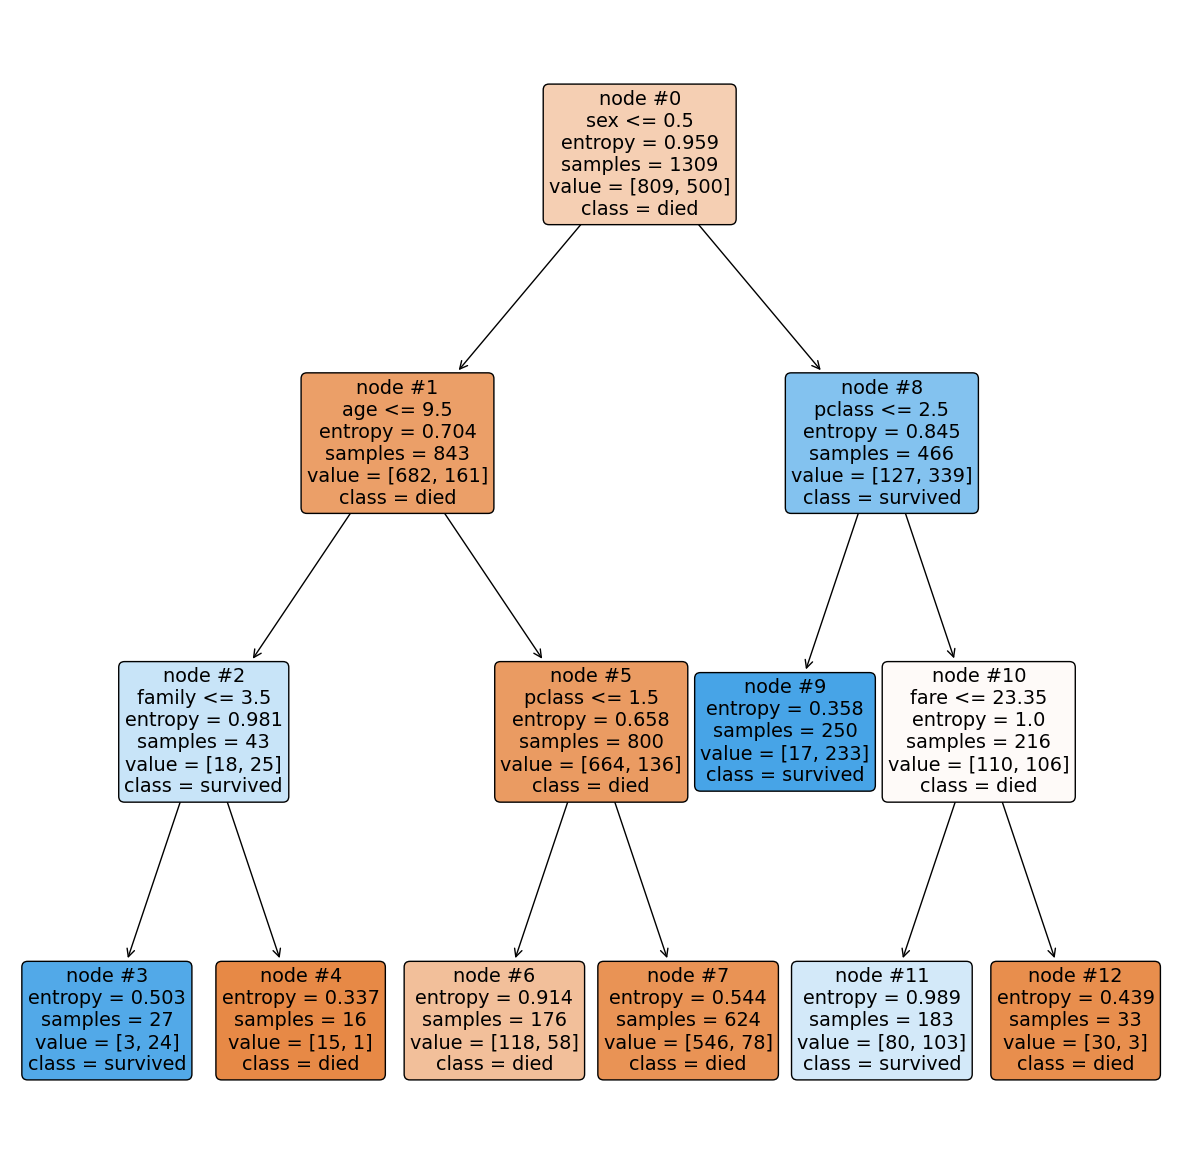

In [176]:
tree_best = final_dict['DecisionTree']['best_model']
tree_best.fit(data_dict['x'], data_dict['y'])

tree_plotter(tree_best, list(X.columns), ['died', 'survived'], fig_size=(15, 15))

"This decision tree achieved an accuracy of around 80%, which is considered adequate for this dataset. Among the various classifiers used in the tree, 'sex' stands out as one of the most influential. It indicates that if a person on the Titanic was a woman, she had a significantly higher chance of surviving this catastrophe.

Further down the tree, in the 'male' node of the second layer, the 'age' classifier becomes prominent in determining survival chances. If a man's age was less than 9.5 years (indicating he was a child), his likelihood of surviving was substantially higher. Moreover, in the third layer, for men with an age less than 9.5, the number of family members they had became crucial. Boys with fewer than 4 family members on the ship had a higher survival rate, while those with more than 4 family members had a lower chance of survival. However, for men more than 9.5 years old the chance of surviving was quite low. Even if they had a first class ticket, their chance of surviving was about 30%.

On the other hand, in the 'female' node of the second layer, 'pclass' (passenger class) played a significant role. The decision tree reveals that women belonging to the first and second classes had a higher likelihood of surviving. Interestingly, even among women in the third class, those who spent less than 22.5 units of money on their ticket had a relatively higher chance of survival (approximately 55% of women in this category survived). This finding highlights the complex interactions between different factors influencing survival.

While the decision tree performed reasonably well on this dataset, there are potential avenues for improving the model's accuracy. One such approach involves using a linear regression model to impute the missing values in the 'age' column, followed by fitting the dataset to the model. This could enhance the model's predictive ability.

Additionally, obtaining a complementary dataset with more passengers' information would be beneficial, as the actual number of passengers on the Titanic was over 2200. Access to more data, particularly on 'cabin' and 'boat' columns, could provide valuable insights and improve the model's performance.

Finally, exploring other classification methods such as Random Forest could offer a comparison to determine which model best fits the Titanic data and potentially yield even better results."

C:\Users\Parsian computer\AppData\Local\Temp\ipykernel_15452\993054647.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row_num, column_num].scatter(
C:\Users\Parsian computer\AppData\Local\Temp\ipykernel_15452\993054647.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row_num, column_num].scatter(
C:\Users\Parsian computer\AppData\Local\Temp\ipykernel_15452\993054647.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row_num, column_num].scatter(
C:\Users\Parsian computer\AppData\Local\Temp\ipykernel_15452\993054647.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row_num, column_num].scatter(
C:\Users\Parsian computer\AppData\Local\Temp\ipykernel_15452\993054647.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row_n

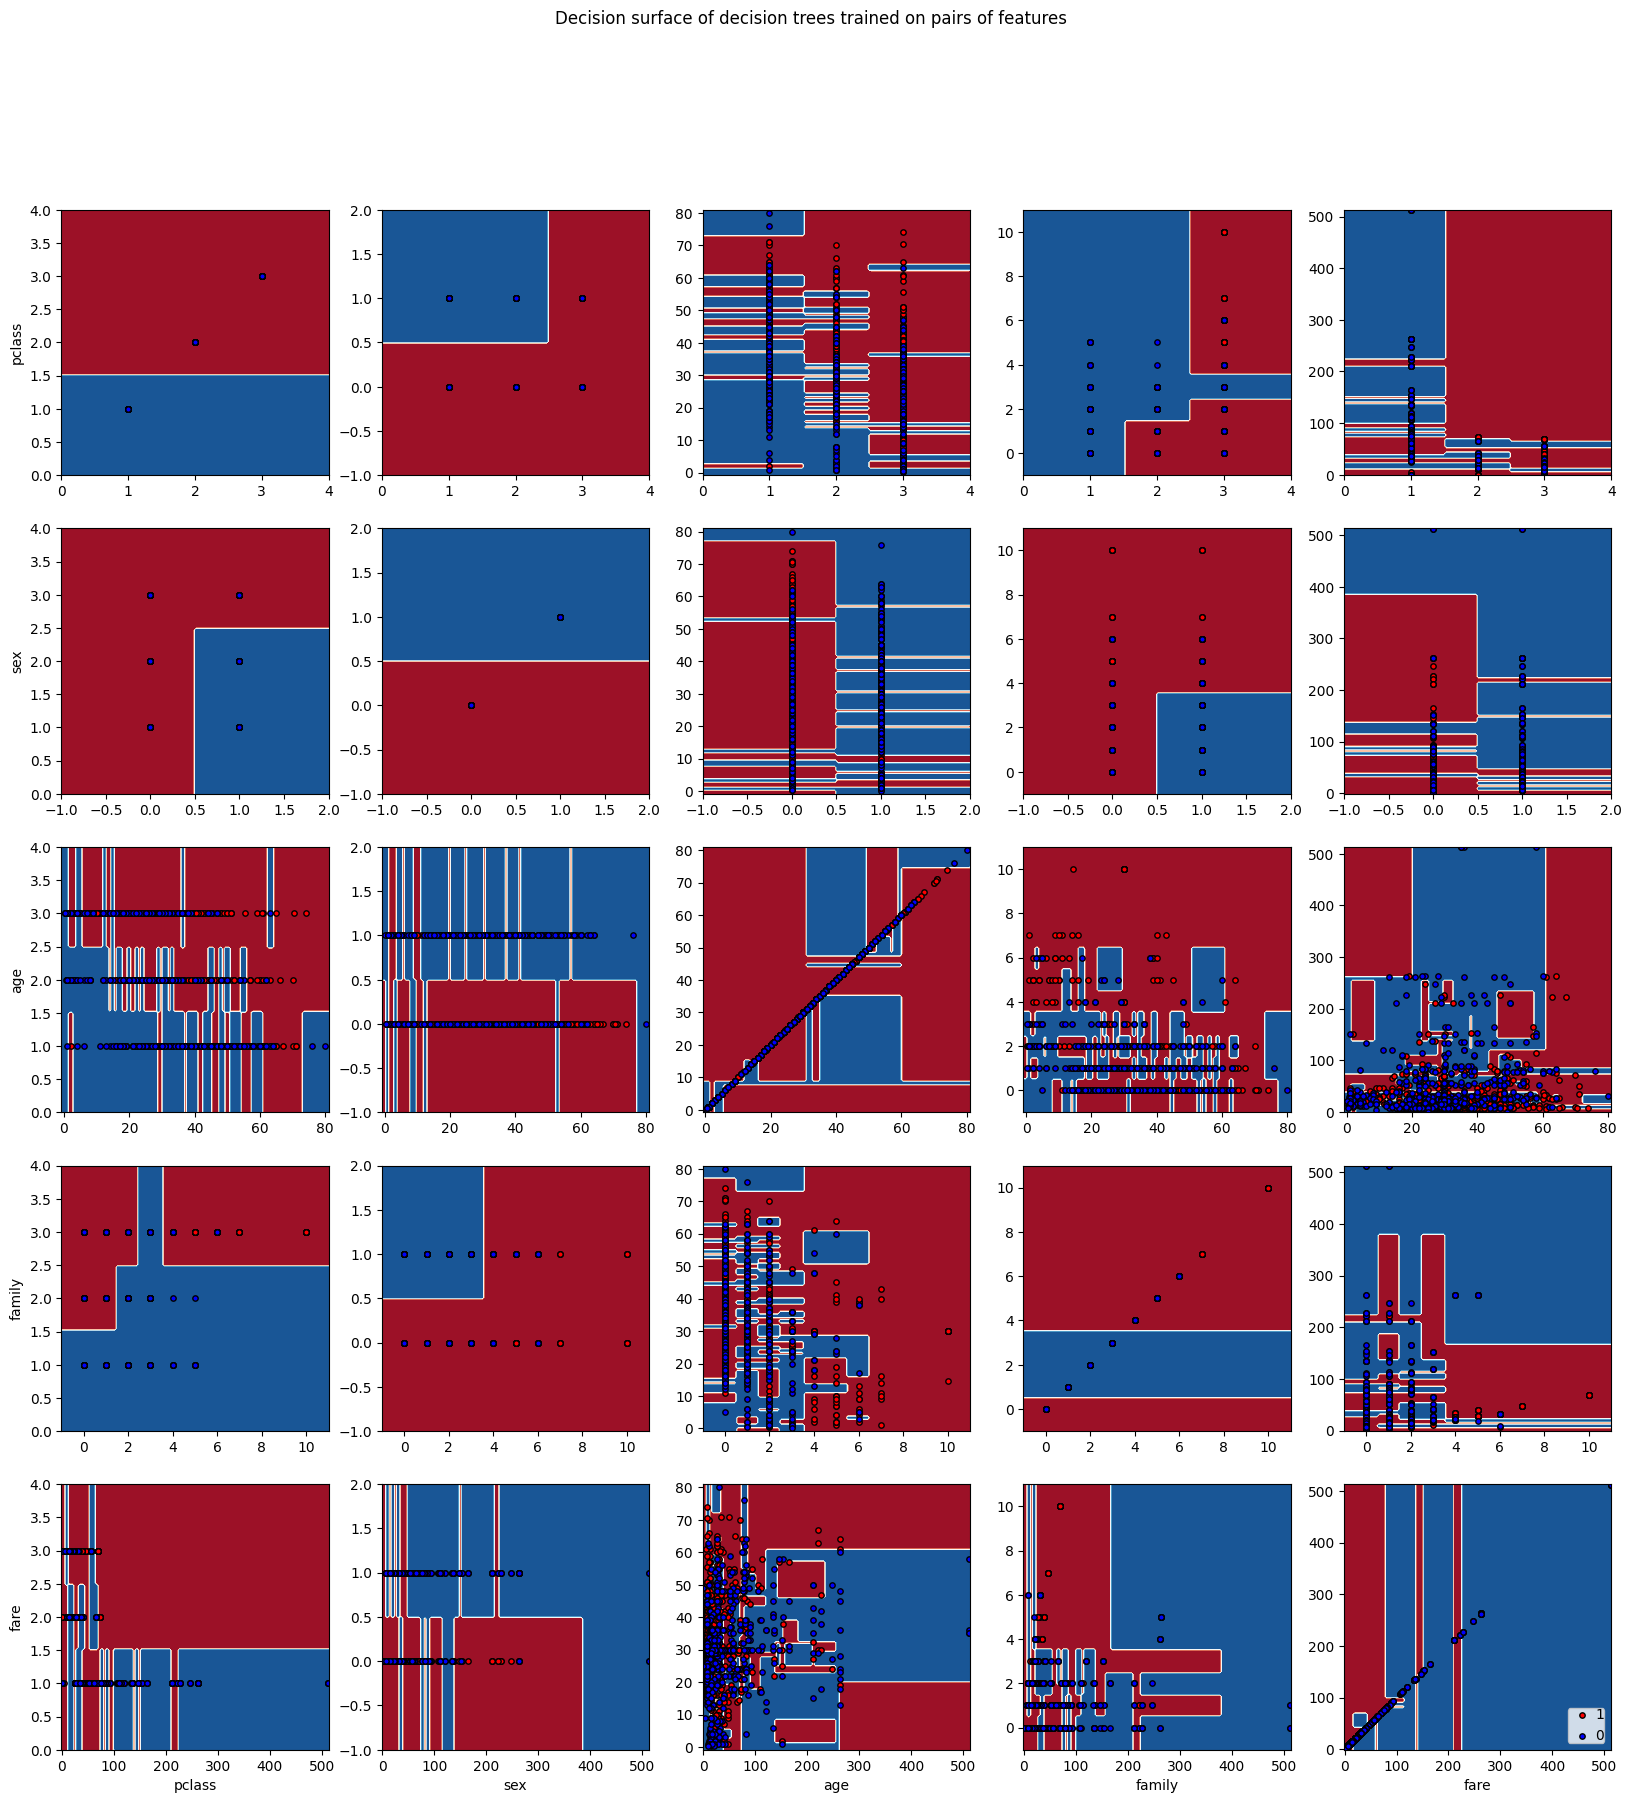


## 3. Naive Bayes 

During the Corona pandemic, seven roommates in a student house did a Corona test. The table below show the data of these students: whether they experiences shivers, had a running nose, or had a headache. The test result is also shown.

Roommate | shivers | running nose | headache | test result
--|--|--|--|--
1 | Y | N | No | Negative
2 | N | N | Mild | Negative
3 | Y | Y | No | Positive
4 | N | Y | No | Negative
5 | N | N | Heavy | Positive
6 | Y | N | No | Negative
7 | Y | Y | Mild | Positive

Explain why it is not useful to include the column 'Roommate' in a classification procedure:

Including the 'Roommate' column in a classification procedure would not be useful because it contains unique identifiers for each student (1 to 7), and these identifiers do not have any predictive power or meaningful relationship with the target variable, which is the 'test result' (Positive or Negative).

In a classification procedure, we aim to predict the target variable (test result) based on the input features (shivers, running nose, headache) that are relevant to the prediction task. The 'Roommate' column does not provide any useful information for this purpose. Each student's identifier is essentially a random and non-informative label assigned to them for identification purposes.

Machine learning models learn patterns and relationships from the data to make predictions. Including the 'Roommate' column as a feature would create a false correlation between the students' identifiers and the test results. This correlation is artificial and has no basis in reality, as the 'Roommate' numbers are simply arbitrary labels assigned to different individuals.

Therefore, to create a meaningful and effective classification model, it is essential to exclude the 'Roommate' column from the input features and focus solely on the relevant features like 'shivers,' 'running nose,' and 'headache' for predicting the test results accurately.

### Implementing Categorical Naive Bayes

Train a [Categorical Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html) classifier on this dataset, where the Test Results are your classes and the other features the data. For this to work, you'll need [Pandas `get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to transform the nominal data into something that sklearn can work with. Use all seven rows in your training.

If you let your fitted classifier predict the test results (based on all the data), you will (hopefully) see that the prediction for observation number 5 (1-based) is wrong (it predicts Negative while the actual value is Positive). Show by manual calculation that the prediction for this instance is indeed higher ($p=0.527$) for the Negative class than for the Positive class.
